In [1]:
from thetis import *
from firedrake_adjoint import *

In [2]:
import adolc
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si
import scipy.optimize as so

In [16]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaBasisOptions
from adapt_utils.norms import vecnorm
from adapt_utils.misc import ellipse

In [12]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

# Forward model

Following the parameter redundancy experiment, we only allow variations in slip.

In [4]:
level = 0
op = TohokuOkadaBasisOptions(level=level, synthetic=False)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0','80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())
print(gauges)
op.active_controls = ['slip']
op.control_parameters['rake'] = np.zeros(*np.shape(op.control_parameters['rake']))
num_active_controls = len(op.active_controls)
op.end_time = 60*30

['801', '802', '803', '804', '806', '807', 'P02', 'P06']


In [5]:
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1

In [6]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1).assign(op.set_coriolis(P1))

In [7]:
boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

In [8]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)
q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

n = FacetNormal(mesh)

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    for tag in boundary_conditions:
        if "freeslip" not in boundary_conditions[tag]:
            F += inner(zeta*n, b*uv)*ds(tag)
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()

bcs = []
for tag in boundary_conditions:
    if "dirichlet" in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

# Source model

Annotate the source model to ADOL-C's tape

ADOL-C: num_independents    : 190
ADOL-C: num_dependents      : 1800
ADOL-C: num_max_lives       : 524288
ADOL-C: tay_stack_size      : 0
ADOL-C: op_buffer_size      : 50000000
ADOL-C: num_operations      : 1372933
ADOL-C: op_file_access      : 0
ADOL-C: num_locations       : 3425924
ADOL-C: loc_file_access     : 0
ADOL-C: num_values          : 685140
ADOL-C: val_file_access     : 0
ADOL-C: loc_buffer_size     : 50000000
ADOL-C: val_buffer_size     : 50000000
ADOL-C: tay_buffer_size     : 50000000


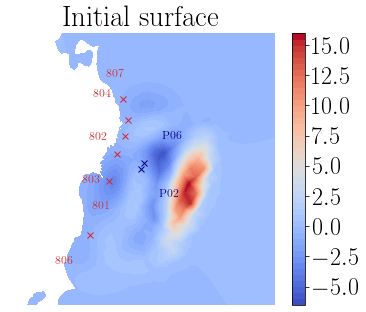

In [13]:
tape_tag = 0
q0 = Function(TaylorHood)
with stop_annotating():
    q0.assign(0.0)
    u0, eta0 = q0.split()
    op.create_topography(annotate=True, tag=tape_tag, separate_faults=False)
    eta0.dat.data[op.indices] = op.fault.dtopo.dZ.reshape(op.fault.dtopo.X.shape)
eta0.dat.name = "Initial surface"

axes = plot_field(eta0);
xg, yg = op.gauges["P02"]["coords"]
axes.set_xlim([xg - 0.3e+06, xg + 0.3e+06]);
axes.set_ylim([yg - 0.35e+06, yg + 0.35e+06]);
op.annotate_plot(axes)

q_init = Function(TaylorHood)
q_init.project(q0)

stats = adolc.tapestats(tape_tag)
for key in stats:
    print("ADOL-C: {:20s}: {:d}".format(key.lower(), stats[key]))
num_subfaults = len(op.subfaults)

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

In [14]:
def solve_forward(init):
    q_.assign(init);
    
    for gauge in gauges:
        op.gauges[gauge]['timeseries'] = []
        op.gauges[gauge]['diff'] = []
        op.gauges[gauge]['timeseries_smooth'] = []
        op.gauges[gauge]['diff_smooth'] = []
        op.gauges[gauge]['init'] = None
        op.gauges[gauge]['data'] = []

    t = 0.0
    iteration = 0
    J = 0
    weight = Constant(1.0)
    eta_obs = Constant(0.0)
    while t < op.end_time:

        # Solve forward equation at current timestep
        solver.solve()

        # Time integrate QoI
        weight.assign(0.5 if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt else 1.0)
        u, eta = q.split()
        for gauge in op.gauges:

            # Point evaluation at gauges
            eta_discrete = eta.at(op.gauges[gauge]["coords"])
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = eta_discrete
            eta_discrete -= op.gauges[gauge]['init']
            op.gauges[gauge]['timeseries'].append(eta_discrete)
                
            # Interpolate observations
            obs = float(op.gauges[gauge]['interpolator'](t))
            eta_obs.assign(obs)
            op.gauges[gauge]['data'].append(obs)

            # Discrete form of error
            diff = 0.5*(eta_discrete - eta_obs.dat.data[0])**2
            op.gauges[gauge]['diff'].append(diff)

            # Continuous form of error
            I = op.gauges[gauge]['indicator']
            diff = 0.5*I*(eta - eta_obs)**2
            J += assemble(weight*dtc*diff*dx)
            op.gauges[gauge]['diff_smooth'].append(assemble(diff*dx, annotate=False))
            op.gauges[gauge]['timeseries_smooth'].append(assemble(I*eta_obs*dx, annotate=False))

        # Increment
        q_.assign(q)
        t += op.dt
        iteration += 1

    assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
    return J

Define gauge indicators

In [17]:
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,), ], mesh), P0)
    op.gauges[gauge]['indicator'].assign(op.gauges[gauge]['indicator']/assemble(op.gauges[gauge]['indicator']*dx))

In [18]:
times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for gauge in gauges:
    op.sample_timeseries(gauge, sample=op.gauges[gauge]['sample'], detide=True)

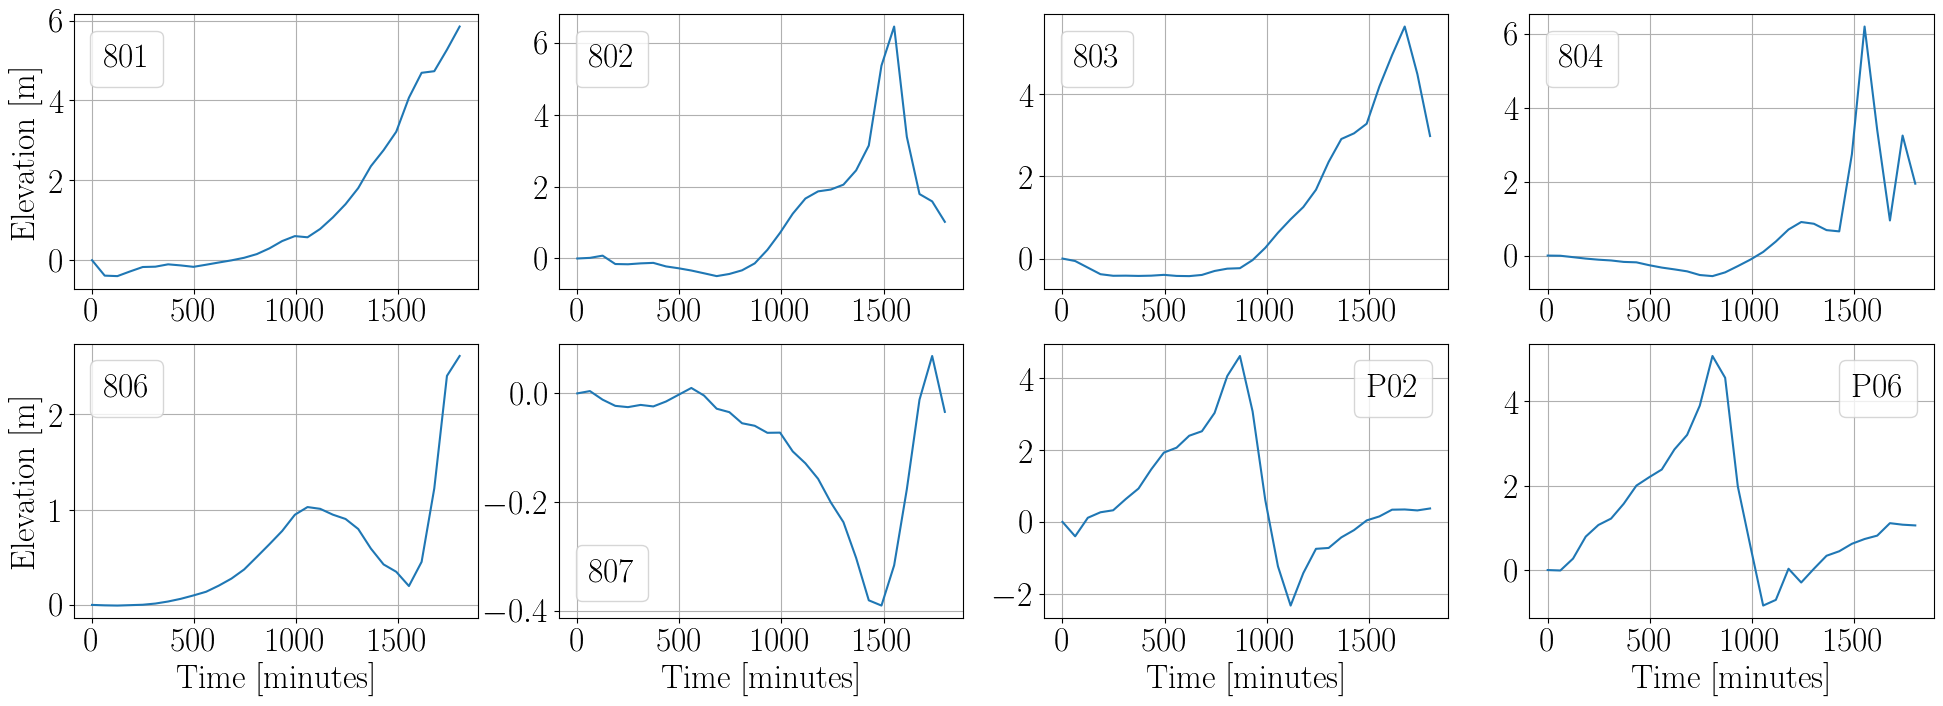

In [19]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 8), dpi=100)
t = np.linspace(0, op.end_time, 150)
for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(times, op.gauges[gauge]['interpolator'](times), label=gauge)
    ax.legend(handlelength=0, handletextpad=0)
    ax.grid(True)
    if i >= 4:
        ax.set_xlabel("Time [minutes]")
    if i%4 == 0:
        ax.set_ylabel("Elevation [m]")

Run tsunami propagation, annotating pyadjoint's tape

In [20]:
J = solve_forward(q_init)
print("Quantity of interest = {:.4e}".format(J))

Quantity of interest = 4.3414e+04


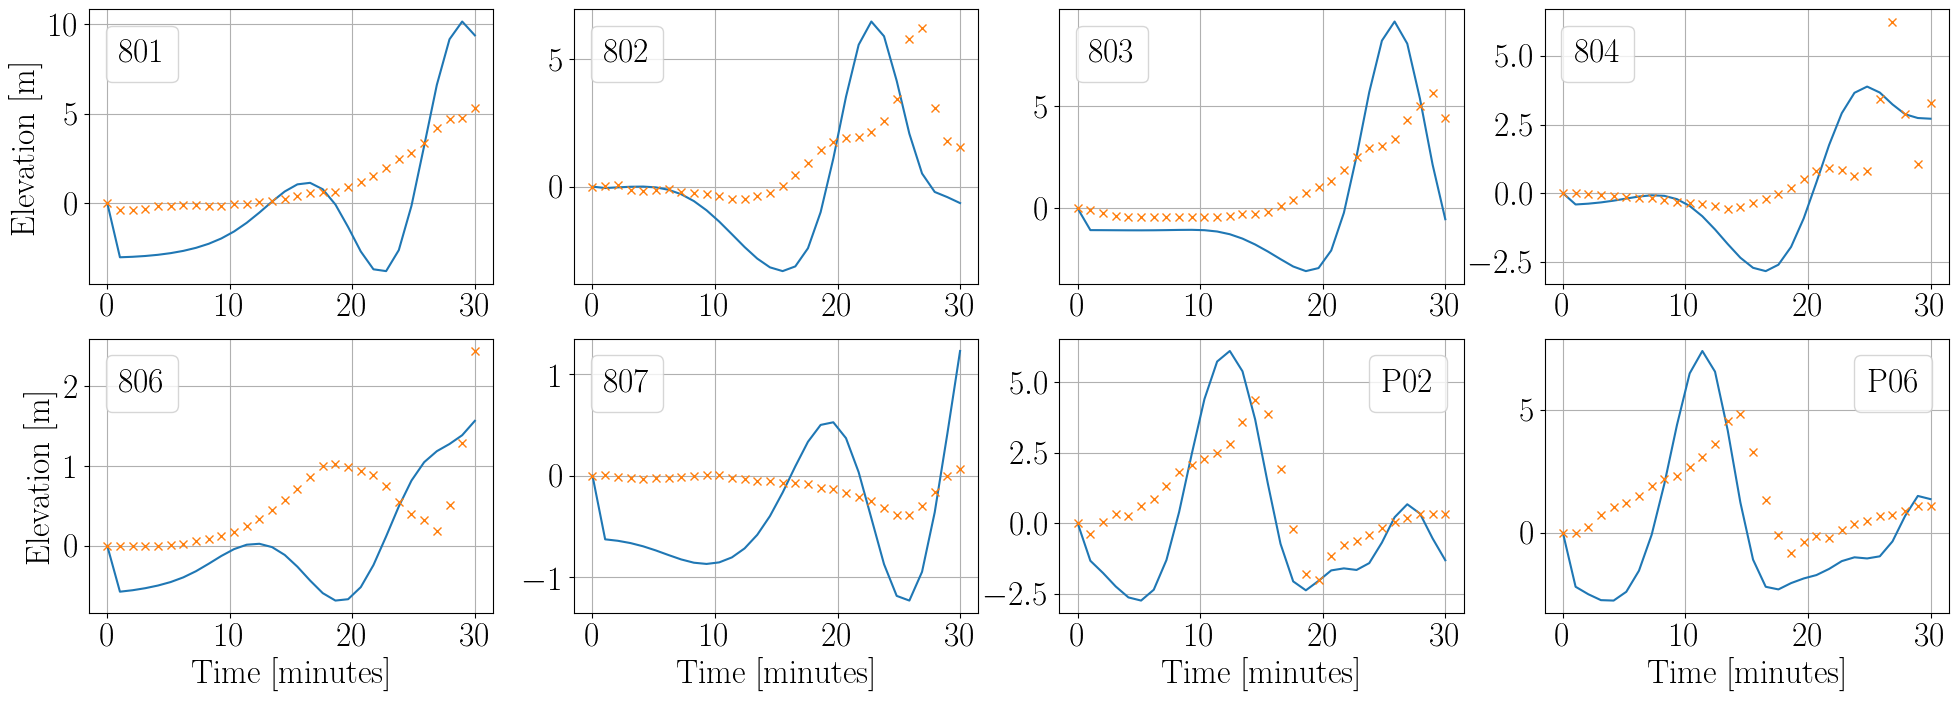

In [21]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 8), dpi=100)

for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(times/60, op.gauges[gauge]['timeseries'], label=gauge)
    ax.plot(times/60, op.gauges[gauge]['data'], 'x')
    ax.legend(handlelength=0, handletextpad=0)
    if i >= 4:
        ax.set_xlabel("Time [minutes]")
    if i%4 == 0:
        ax.set_ylabel("Elevation [m]")
    ax.grid(True)

## Discrete adjoint

Note that we only Taylor test the elevation and effectively zero out the perturbation away from the source.

In [22]:
c = Control(q_init)

In [23]:
stop_annotating();

In [24]:
rf_pyadjoint = ReducedFunctional(J, c)

In [26]:
np.random.seed(0)
m0 = Function(TaylorHood).assign(q_init)
dm0 = Function(TaylorHood)
dm0.dat.data[1][:] = np.random.rand(*dm0.dat.data[1].shape)*m0.dat.data[1]
minconv = taylor_test(rf_pyadjoint, m0, dm0)
assert minconv > 1.90, minconv

Running Taylor test
Computed residuals: [1.0901093069887224, 0.2721606186809993, 0.06831553020241188, 0.017136225629307944]
Computed convergence rates: [2.0019425727810063, 1.9941728362097193, 1.995164203351393]


In [35]:
def rf_pyadolc(m):
    m_array = m.reshape((num_active_controls, num_subfaults))
    for i, control in enumerate(op.active_controls):
        assert len(op.control_parameters[control]) == len(m_array[i])
        op.control_parameters[control][:] = m_array[i]
    q0_tmp = Function(TaylorHood)
    q0_tmp.assign(0.0)
    u0_tmp, eta0_tmp = q0_tmp.split()
    eta0_tmp.dat.data[op.indices] = adolc.zos_forward(tape_tag, op.input_vector, keep=1)
    return q0_tmp

In [30]:
def reduced_functional(m):
    """
    Compose both unrolled tapes
    """
    J = rf_pyadjoint(rf_pyadolc(m))
    print("Reduced functional = {:.8e}".format(J))
    return J

In [31]:
def gradient(m):
    """
    Apply the chain rule to both tapes
    """
    J = rf_pyadjoint(rf_pyadolc(m))
    dJdq0 = rf_pyadjoint.derivative()
    dJdu0, dJdeta0 = dJdq0.split()
    dJdeta0 = dJdeta0.dat.data[op.indices]
    dJdm = adolc.fos_reverse(tape_tag, dJdeta0)
    print("Gradient norm      = {:.8e}".format(vecnorm(dJdm, order=np.Inf)))
    return dJdm

In [32]:
c = np.array(op.control_parameters['slip']).flatten()

In [33]:
def callback(m):
    print("Line search complete")

In [ ]:
# Run optimisation
print_output("Optimisation begin...")
opt_kwargs = {
    'maxiter': 1000,
    'gtol': 1.0e-08,
    'fprime': gradient,
    'callback': callback,
}
optimised_value = so.fmin_bfgs(reduced_functional, c, **opt_kwargs)

Optimisation begin...


Reduced functional = 4.34143042e+04
Gradient norm      = 1.49598380e+02
Reduced functional = 4.29072788e+04
Gradient norm      = 1.48305107e+02
Reduced functional = 4.09371023e+04
Gradient norm      = 1.43132011e+02
Reduced functional = 3.39832324e+04
Gradient norm      = 1.22439652e+02
Line search complete
Reduced functional = 2.21504203e+04
Gradient norm      = 9.44331469e+01
Line search complete
Reduced functional = 1.40939960e+04
Gradient norm      = 4.63679039e+01
Line search complete
Reduced functional = 2.33378008e+04
Gradient norm      = 1.07617010e+02
Reduced functional = 1.16843666e+04
Gradient norm      = 3.24033641e+01
Line search complete
Reduced functional = 1.29684491e+04
Gradient norm      = 4.40373609e+01
Reduced functional = 1.07215136e+04
Gradient norm      = 2.26471984e+01
Line search complete
Reduced functional = 1.04066491e+04
Gradient norm      = 1.94323288e+01
Line search complete
Reduced functional = 9.91289408e+03
Gradient norm      = 1.56305418e+01
Line searc

Reduced functional = 4.97968971e+03
Gradient norm      = 5.04287911e-01
Line search complete
Reduced functional = 4.97259289e+03
Gradient norm      = 5.84936216e-01
Line search complete
Reduced functional = 4.96592861e+03
Gradient norm      = 6.92571685e-01
Line search complete
Reduced functional = 4.95986513e+03
Gradient norm      = 5.66687735e-01
Line search complete
Reduced functional = 4.95430350e+03
Gradient norm      = 4.46969277e-01
Line search complete
Reduced functional = 4.94852607e+03
Gradient norm      = 5.32360488e-01
Line search complete
Reduced functional = 4.94168990e+03
Gradient norm      = 5.64855503e-01
Line search complete
Reduced functional = 4.93371482e+03
Gradient norm      = 5.09622824e-01
Line search complete
Reduced functional = 4.92553381e+03
Gradient norm      = 5.01032372e-01
Line search complete
Reduced functional = 4.91812137e+03
Gradient norm      = 4.33072239e-01
Line search complete
Reduced functional = 4.91160381e+03
Gradient norm      = 5.43553027e-0

Gradient norm      = 1.66029857e-01
Line search complete
Reduced functional = 4.72990694e+03
Gradient norm      = 1.65284564e-01
Line search complete
Reduced functional = 4.72901691e+03
Gradient norm      = 1.60711075e-01
Line search complete
Reduced functional = 4.72804720e+03
Gradient norm      = 1.64880979e-01
Line search complete
Reduced functional = 4.72699628e+03
Gradient norm      = 1.68187375e-01
Line search complete
Reduced functional = 4.72588933e+03
Gradient norm      = 1.75534977e-01
Line search complete
Reduced functional = 4.72466584e+03
Gradient norm      = 2.00133457e-01
Line search complete
Reduced functional = 4.72326354e+03
Gradient norm      = 2.30594071e-01
Line search complete
Reduced functional = 4.72178813e+03
Gradient norm      = 1.98506953e-01
Line search complete
Reduced functional = 4.72042131e+03
Gradient norm      = 1.87888343e-01
Line search complete
Reduced functional = 4.71915820e+03
Gradient norm      = 1.71280400e-01
Line search complete
Reduced funct

Reduced functional = 4.65319452e+03
Gradient norm      = 1.21072015e-01
Line search complete
Reduced functional = 4.65256155e+03
Gradient norm      = 1.41312539e-01
Line search complete
Reduced functional = 4.65161382e+03
Gradient norm      = 1.45385579e-01
Line search complete
Reduced functional = 4.65087539e+03
Gradient norm      = 1.15057837e-01
Line search complete
Reduced functional = 4.65049279e+03
Gradient norm      = 1.00811177e-01
Line search complete
Reduced functional = 4.65017086e+03
Gradient norm      = 9.14018706e-02
Line search complete
Reduced functional = 4.64980030e+03
Gradient norm      = 1.22179115e-01
Line search complete
Reduced functional = 4.64918429e+03
Gradient norm      = 1.41178171e-01
Line search complete
Reduced functional = 4.64819941e+03
Gradient norm      = 1.40374321e-01
Line search complete
Reduced functional = 4.64700119e+03
Gradient norm      = 1.26414683e-01
Line search complete
Reduced functional = 4.64649079e+03
Gradient norm      = 8.24529534e-0

Gradient norm      = 4.25081534e-02
Line search complete
Reduced functional = 4.61957240e+03
Gradient norm      = 4.35431487e-02
Line search complete
Reduced functional = 4.61905064e+03
Gradient norm      = 4.67425611e-02
Line search complete
Reduced functional = 4.61830169e+03
Gradient norm      = 4.88862515e-02
Line search complete
Reduced functional = 4.61786583e+03
Gradient norm      = 4.26267679e-02
Line search complete
Reduced functional = 4.61766495e+03
Gradient norm      = 4.01368743e-02
Line search complete
Reduced functional = 4.61757537e+03
Gradient norm      = 4.35895575e-02
Line search complete
Reduced functional = 4.61751032e+03
Gradient norm      = 4.77242925e-02
Line search complete
Reduced functional = 4.61739774e+03
Gradient norm      = 4.91813186e-02
Line search complete
Reduced functional = 4.61720003e+03
Gradient norm      = 4.72893092e-02
Line search complete
Reduced functional = 4.61686489e+03
Gradient norm      = 3.91717563e-02
Line search complete
Reduced funct

Reduced functional = 4.59489343e+03
Gradient norm      = 2.64410328e-02
Line search complete
Reduced functional = 4.59477843e+03
Gradient norm      = 2.48466432e-02
Line search complete
Reduced functional = 4.59457074e+03
Gradient norm      = 2.50682484e-02
Line search complete
Reduced functional = 4.59420297e+03
Gradient norm      = 2.67754437e-02
Line search complete
Reduced functional = 4.59359199e+03
Gradient norm      = 3.12984069e-02
Line search complete
Reduced functional = 4.59275339e+03
Gradient norm      = 4.14761393e-02
Line search complete
Reduced functional = 4.59228051e+03
Gradient norm      = 3.94824112e-02
Line search complete
Reduced functional = 4.59195061e+03
Gradient norm      = 3.34804190e-02
Line search complete
Reduced functional = 4.59186159e+03
Gradient norm      = 3.10123198e-02
Line search complete
Reduced functional = 4.59182388e+03
Gradient norm      = 3.05204946e-02
Line search complete
Reduced functional = 4.59176072e+03
Gradient norm      = 2.99310751e-0

In [ ]:
q0_opt = rf_pyadolc(optimised_value)
q_opt = rf_pyadjoint(q0_opt)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(19, 8))
for i, f in enumerate((q0_opt, q)):
    u_opt, eta_opt = q.split()
    tc = tricontourf(eta_opt, axes=axes[i], cmap='coolwarm', levels=50)
    cbar = fig.colorbar(tc, ax=axes[i])
    axes[i].axis(False);

# TODO:
* Plot optimisation progress
* Plot timeseries